In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba # For Just-In-Time (JIT) compilation to speed up numerical functions
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure # For energy calculations using convolution
from tqdm import tqdm

In [2]:
# Parameters
N = 20  # Lattice size (20x20 grid)
Ts = np.arange(1, 4, 0.1)  # Temperature range

# Initialize a lattice with 75% spins set to -1 (negative-biased configuration)
init_random = np.random.random((N,N))
lattice_n = np.zeros((N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

# Initialize a lattice with 75% spins set to +1 (positive-biased configuration)
init_random = np.random.random((N,N))
lattice_p = np.zeros((N, N))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1


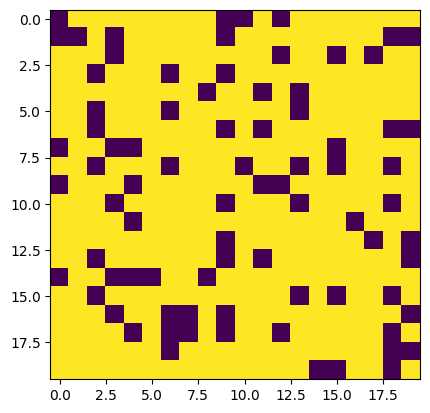

In [3]:
plt.imshow(lattice_p)

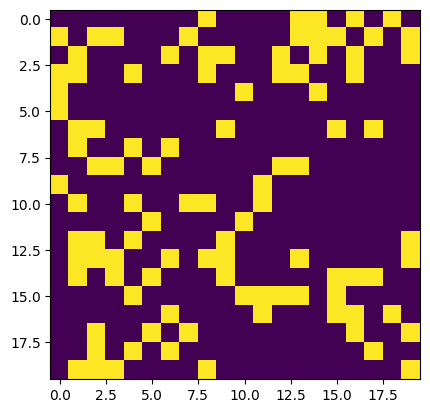

In [4]:
plt.imshow(lattice_n)

In [5]:

def get_energy(lattice, B_ext):
    """
    Compute the total energy of the lattice using nearest-neighbor interactions.
    """
    kern = generate_binary_structure(2, 1)  # Convolution kernel for neighbors
    kern[1][1] = False  # Exclude the center spin itself
    neighbor_energy = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    external_field_energy = -B_ext * lattice.sum()
    return neighbor_energy.sum() + external_field_energy

@njit("UniTuple(f8[:], 3)(f8[:,:], i8, f8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, t, energy, B_ext):
    """
    Perform the Metropolis algorithm for a given number of steps.
    Args:
        spin_arr: Initial lattice configuration.
        times: Number of Monte Carlo steps.
        t: Temperature.
        energy: Initial energy of the lattice.
        B_ext: External magnetic field.
    Returns:
        net_spins: Array of magnetizations at each step.
        net_energy: Array of energies at each step.
        mag_sq: Array of square of magnetizations at each step.
    """
    J = 1  # Interaction strength
    k = 1  # Boltzmann constant
    beta = 1 / (t * k)  # Inverse temperature
    spin_arr = spin_arr.copy()  # Ensure the lattice is not modified in-place
    net_spins = np.zeros(times - 1)
    net_energy = np.zeros(times - 1)
    mag_sq = np.zeros(times - 1)

    for s in range(0, times - 1):
        # Pick a random spin in the lattice
        i = np.random.randint(0, N)
        j = np.random.randint(0, N)
        spin_i = spin_arr[i, j]  # Initial spin

        # Compute the energy difference if this spin is flipped
        neighbors = spin_arr[(i + 1) % N, j] + spin_arr[i, (j + 1) % N] + \
                    spin_arr[(i - 1) % N, j] + spin_arr[i, (j - 1) % N]
        dE = 2 * J * spin_i * neighbors + 2 * B_ext * spin_i

        # Decide whether to flip the spin based on Metropolis criterion
        if dE < 0 or np.random.rand() < np.exp(-beta * dE):
            spin_arr[i, j] *= -1  # Flip the spin
            energy += dE

        # Record net magnetization, square of magnetization, and energy
        net_spins[s] = spin_arr.sum()
        mag_sq[s] = net_spins[s] ** 2
        net_energy[s] = energy

    return net_spins, net_energy, mag_sq

def get_spin_energy(lattice, Ts, B_ext):
    """
    Compute magnetization, average energy, energy fluctuations, and susceptibility.
    Args:
        lattice: Initial lattice configuration (float64).
        Ts: Array of temperatures.
        B_ext: External magnetic field.
    Returns:
        ms: Average magnetization at each temperature.
        E_means: Average energy at each temperature.
        E_stds: Energy standard deviation at each temperature.
        susceptibilities: Magnetic susceptibility at each temperature.
    """
    ms = np.zeros(len(Ts))
    E_means = np.zeros(len(Ts))
    E_stds = np.zeros(len(Ts))
    susceptibilities = np.zeros(len(Ts))
    
    for i, t in tqdm(enumerate(Ts), total=len(Ts), desc="Simulating Temperatures"):
        initial_energy = float(get_energy(lattice, B_ext))
        spins, energies, mag_sq = metropolis(lattice, 1000000, t, initial_energy, B_ext)

        ms[i] = np.abs(spins[-100000:]).mean() # / N**2  # Normalize magnetization per spin
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
        susceptibilities[i] = (mag_sq[-100000:].mean() - (spins[-100000:].mean()) ** 2) / t
    
    return ms, E_means, E_stds, susceptibilities


C:\Users\Asus\anaconda3\Lib\site-packages\numba\core\decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [6]:

# Simulate for two lattices with B_ext = 1 (Problem 1)
B_ext = 0
ms_n, E_means_n, E_stds_n, chi_n = get_spin_energy(lattice_n, Ts, B_ext)
ms_p, E_means_p, E_stds_p, chi_p = get_spin_energy(lattice_p, Ts, B_ext)



Simulating Temperatures: 100%|█████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.85it/s]


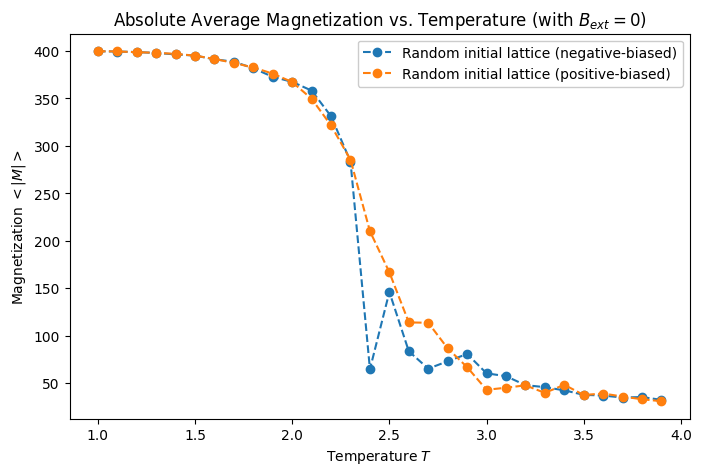

In [7]:
# Plot magnetization results
plt.figure(figsize=(8, 5))
plt.plot(Ts, ms_n, 'o--', label='Random initial lattice (negative-biased)')
plt.plot(Ts, ms_p, 'o--', label='Random initial lattice (positive-biased)')
plt.xlabel(r'Temperature $T$')
plt.ylabel(r'Magnetization $<|M|>$')
plt.legend(facecolor='white', framealpha=1)
plt.title("Absolute Average Magnetization vs. Temperature (with $B_{ext}=0$)")
plt.show()

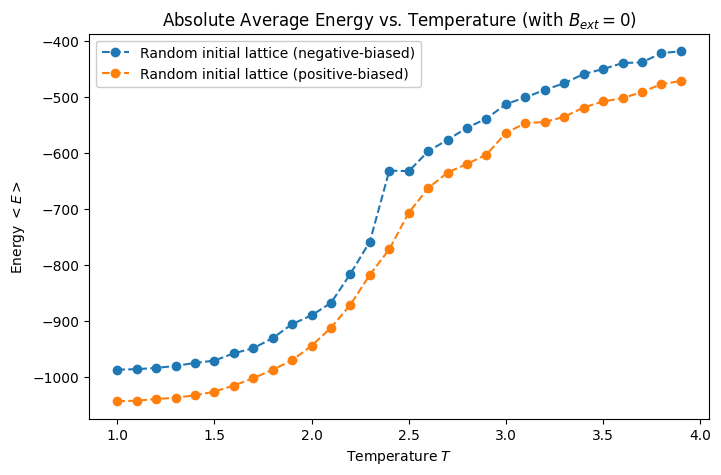

In [8]:
# Plot magnetization results
plt.figure(figsize=(8, 5))
plt.plot(Ts, E_means_n, 'o--', label='Random initial lattice (negative-biased)')
plt.plot(Ts, E_means_p, 'o--', label='Random initial lattice (positive-biased)')
plt.xlabel(r'Temperature $T$')
plt.ylabel(r'Energy $<{E}>$')
plt.legend(facecolor='white', framealpha=1)
plt.title("Absolute Average Energy vs. Temperature (with $B_{ext}=0$)")
plt.show()

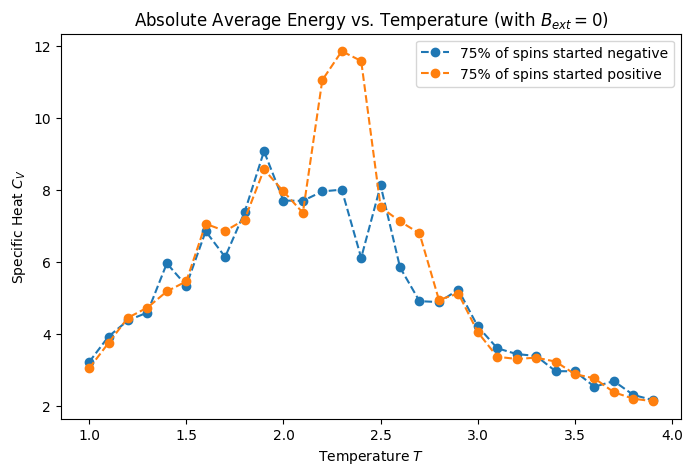

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(Ts, E_stds_n / Ts ** 2, 'o--', label='75% of spins started negative')
plt.plot(Ts, E_stds_p / Ts ** 2, 'o--', label='75% of spins started positive')
plt.xlabel(r'Temperature $T$')
plt.ylabel(r'Specific Heat $C_V$')
plt.title("Absolute Average Energy vs. Temperature (with $B_{ext}=0$)")
plt.legend()
plt.show()

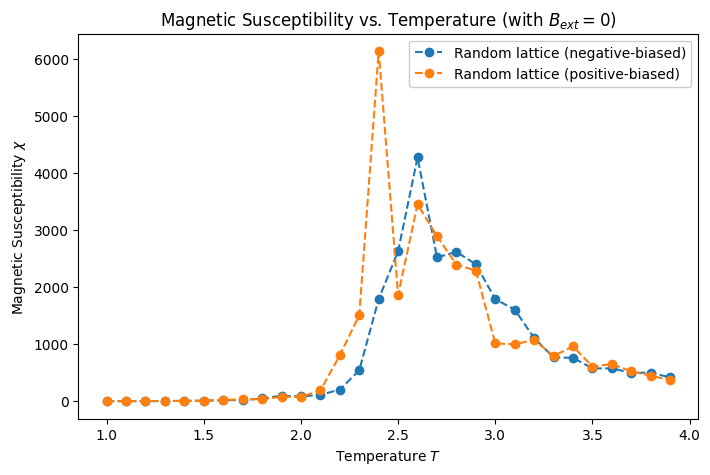

In [10]:

# Plot Magnetic Susceptibility
plt.figure(figsize=(8, 5))
plt.plot(Ts, chi_n, 'o--', label='Random lattice (negative-biased)')
plt.plot(Ts, chi_p, 'o--', label='Random lattice (positive-biased)')
plt.xlabel(r'Temperature $T$')
plt.ylabel(r'Magnetic Susceptibility $\chi$')
plt.legend(facecolor='white', framealpha=1)
plt.title("Magnetic Susceptibility vs. Temperature (with $B_{ext}=0$)")
plt.show()

In [11]:

# Simulate for two lattices with B_ext = 1 (Problem 2)
B_ext = 1
ms_n, E_means_n, E_stds_n, chi_n = get_spin_energy(lattice_n, Ts, B_ext)
ms_p, E_means_p, E_stds_p, chi_p = get_spin_energy(lattice_p, Ts, B_ext)


Simulating Temperatures: 100%|█████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.84it/s]


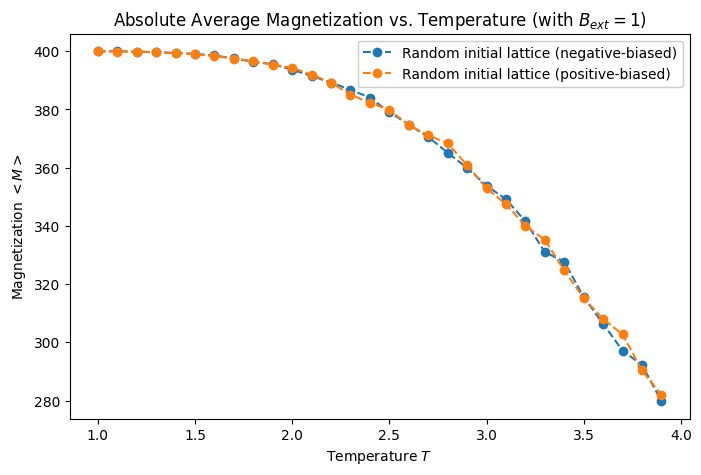

In [12]:
# Plot magnetization results
plt.figure(figsize=(8, 5))
plt.plot(Ts, ms_n, 'o--', label='Random initial lattice (negative-biased)')
plt.plot(Ts, ms_p, 'o--', label='Random initial lattice (positive-biased)')
plt.xlabel(r'Temperature $T$')
plt.ylabel(r'Magnetization $<{M}>$')
plt.legend(facecolor='white', framealpha=1)
plt.title("Absolute Average Magnetization vs. Temperature (with $B_{ext}=1$)")
plt.show()

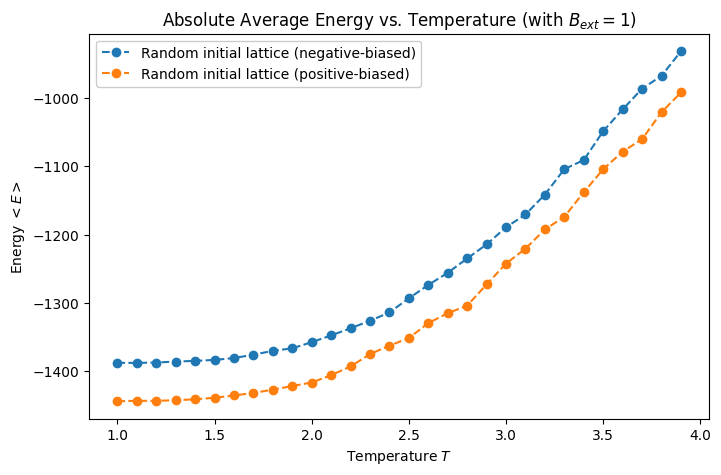

In [13]:
# Plot magnetization results
plt.figure(figsize=(8, 5))
plt.plot(Ts, E_means_n, 'o--', label='Random initial lattice (negative-biased)')
plt.plot(Ts, E_means_p, 'o--', label='Random initial lattice (positive-biased)')
plt.xlabel(r'Temperature $T$')
plt.ylabel(r'Energy $<{E}>$')
plt.legend(facecolor='white', framealpha=1)
plt.title("Absolute Average Energy vs. Temperature (with $B_{ext}=1$)")
plt.show()

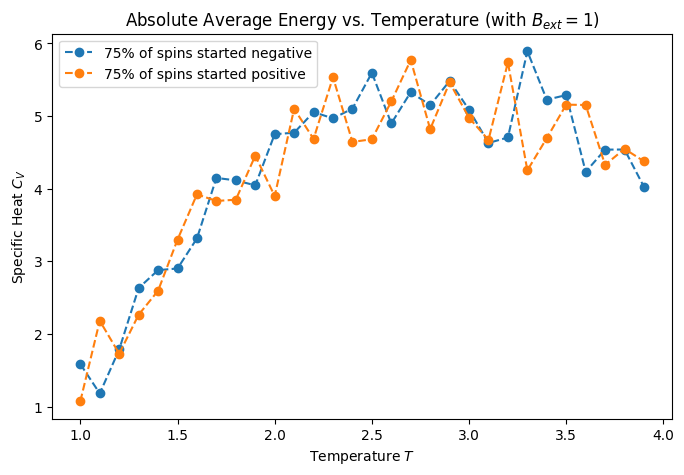

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(Ts, E_stds_n / Ts ** 2, 'o--', label='75% of spins started negative')
plt.plot(Ts, E_stds_p / Ts ** 2, 'o--', label='75% of spins started positive')
plt.xlabel(r'Temperature $T$')
plt.ylabel(r'Specific Heat $C_V$')
plt.title("Absolute Average Energy vs. Temperature (with $B_{ext}=1$)")
plt.legend()
plt.show()

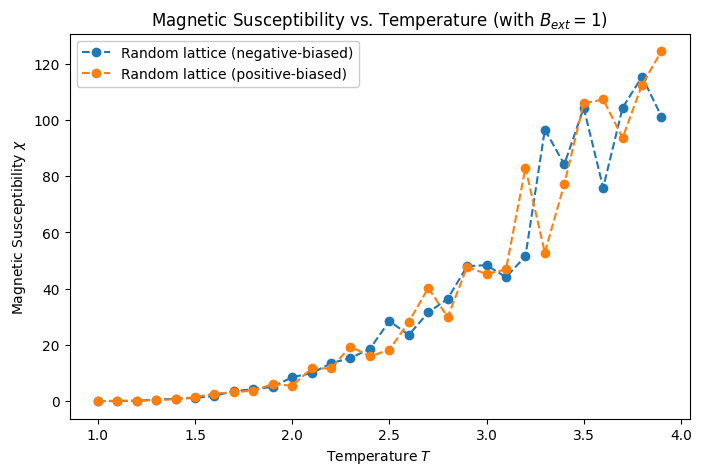

In [15]:

# Plot Magnetic Susceptibility
plt.figure(figsize=(8, 5))
plt.plot(Ts, chi_n, 'o--', label='Random lattice (negative-biased)')
plt.plot(Ts, chi_p, 'o--', label='Random lattice (positive-biased)')
plt.xlabel(r'Temperature $T$')
plt.ylabel(r'Magnetic Susceptibility $\chi$')
plt.legend(facecolor='white', framealpha=1)
plt.title("Magnetic Susceptibility vs. Temperature (with $B_{ext}=1$)")
plt.show()